# Определение возраста покупателей

## Исследовательский анализ данных

### Загрузка библиотек

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
pd.set_option('display.max_colwidth', None)

### Загрузка меток

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',  # Возвращает вещественные значения меток
        seed=12345)

Found 7591 validated image filenames.


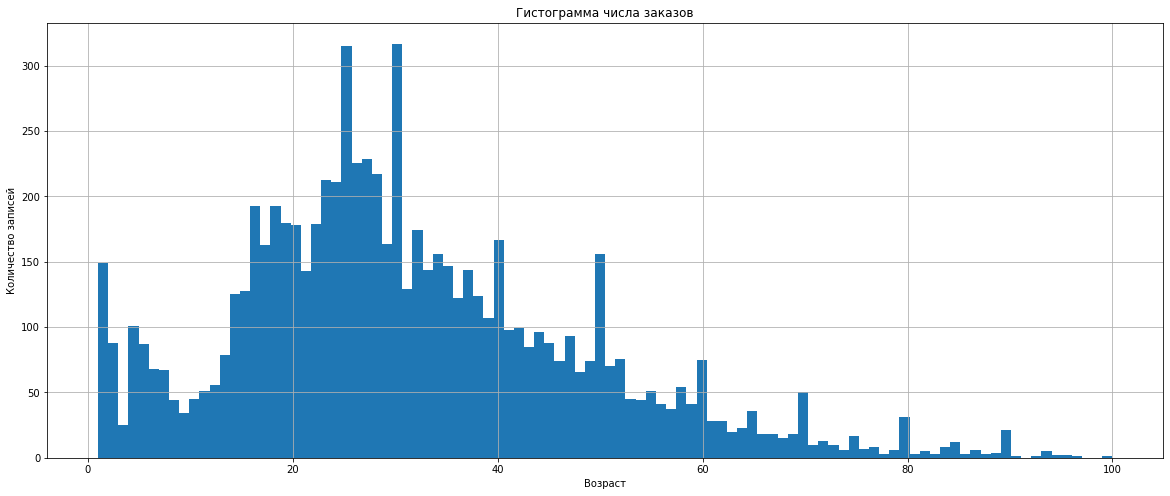

In [5]:
labels.hist(bins=100)
plt.ylabel('Количество записей')
plt.xlabel('Возраст')
plt.title("Гистограмма числа заказов");

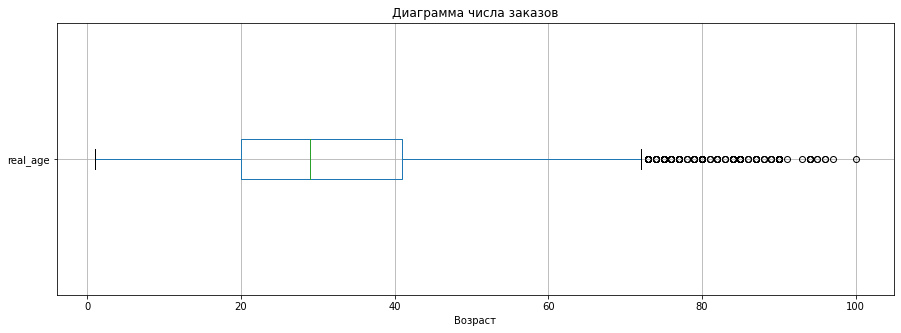

In [6]:
labels.boxplot(figsize=(15,5), vert=False)
plt.xlabel('Возраст')
plt.title("Диаграмма числа заказов");

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


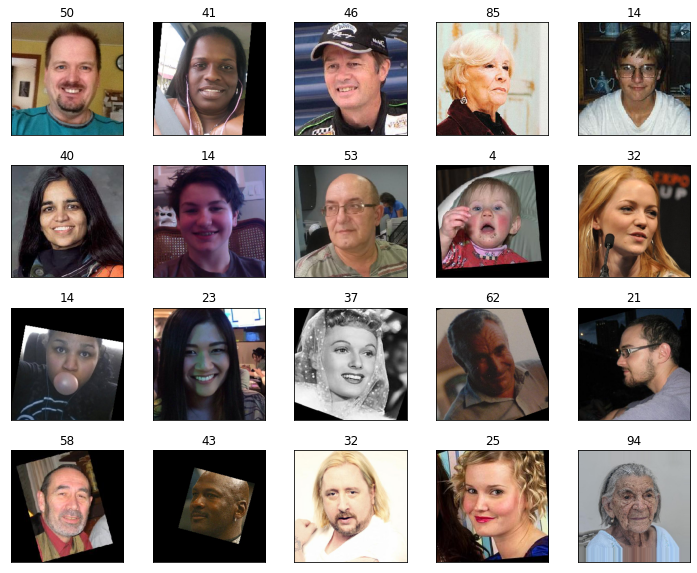

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10, 10))
for i in range(20):  # Исправлено на 16, так как 4х4 = 16 изображений
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.show()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):

    labels = pd.read_csv(path + '/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2] 
    )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow


def load_test(path):

    labels = pd.read_csv(path + '/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        classes=1000,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
   
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 







```

```
Epoch 1/10
2024-09-23 19:37:19.048386: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-09-23 19:37:20.265664: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 151s - loss: 229.3566 - mae: 10.8947 - val_loss: 775.5063 - val_mae: 22.7946
Epoch 2/10
190/190 - 123s - loss: 89.2540 - mae: 7.1488 - val_loss: 726.3785 - val_mae: 21.8548
Epoch 3/10
190/190 - 122s - loss: 70.9798 - mae: 6.4014 - val_loss: 297.5077 - val_mae: 12.8878
Epoch 4/10
190/190 - 132s - loss: 58.4512 - mae: 5.8869 - val_loss: 160.5953 - val_mae: 9.6749
Epoch 5/10
190/190 - 135s - loss: 49.2603 - mae: 5.3913 - val_loss: 71.3520 - val_mae: 6.3723
Epoch 6/10
190/190 - 142s - loss: 42.3863 - mae: 5.0083 - val_loss: 79.1482 - val_mae: 6.4830
Epoch 7/10
190/190 - 142s - loss: 35.8697 - mae: 4.5914 - val_loss: 78.9958 - val_mae: 6.4562
Epoch 8/10
190/190 - 144s - loss: 33.5447 - mae: 4.4737 - val_loss: 83.0087 - val_mae: 6.6303
Epoch 9/10
190/190 - 143s - loss: 29.9615 - mae: 4.2453 - val_loss: 68.2108 - val_mae: 6.1472
Epoch 10/10
190/190 - 141s - loss: 28.0155 - mae: 4.0940 - val_loss: 65.1754 - val_mae: 5.8949
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 11s - loss: 65.1754 - mae: 5.8949
Test MAE: 5.8949
```

## Анализ обученной модели

5.8949 - ошибка в определении возраста. На трейне модель переобучилась, mae = 4.0940, на валиде это не сказалось. Обучена на 10 эпохах на ResNet50 с использованием алгоритма оптимизации Adam(lr=0.0001). В выборке больше людей в возрасте от 18 до 40 лет, но судя по написанной научной статье данный результат можно считать хорошим. Были применны разлличные аугментации:
        
        Отражение по горизонтали,
        Поворот на 10 градусов,
        Горизонтальные сдвиги,
        Вертикальные сдвиги,
        Изменение яркости